In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings
import utils
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats.stats import pearsonr   
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

params = utils.Params('init_params.json')

In [47]:
csv_path = params.csv_path
dataset = params.dataset
window_size = params.window_size
stride_size = params.stride_size
num_covariates = params.num_covariates
pred_days= params.pred_days

In [48]:
lag= window_size-pred_days-stride_size

### Load Data 

In [49]:
df_org=pd.read_csv(csv_path, index_col='Date', parse_dates=['Date'])
print('Number of rows and columns:', df_org.shape)
# Looking at the PM2.5 column
df = df_org.copy()
df.head(5)

Number of rows and columns: (2342, 10)


,PM2.5,PM10,SO2,CO,NOx,O3,WS,Temp,RH,RF
Date,,,,,,,,,,
2013-01-01,240.365653,404.141923,4.0392,0.3567,19.6254,6.5769,1.3795,17.8800,69.8887,0.0583
2013-01-02,267.760636,447.535746,3.9436,0.3086,13.4329,4.5049,1.4104,18.6961,67.1973,0.0467
2013-01-03,262.088263,449.070512,3.8702,0.3405,16.0926,5.3954,1.6614,20.0829,68.4158,0.0482
2013-01-04,222.661851,372.724157,4.2239,0.3858,19.5855,6.5480,1.2790,20.1200,70.4625,0.0226
2013-01-05,164.089142,278.164502,4.0392,0.5365,31.8197,10.6209,1.3413,18.7043,62.1733,0.0200


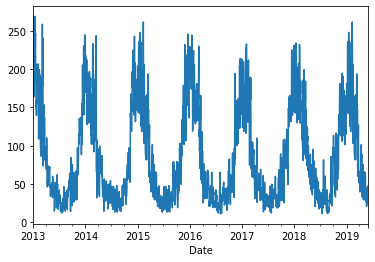

In [50]:
## Plotting pm2.5 values
df['PM2.5'].plot()

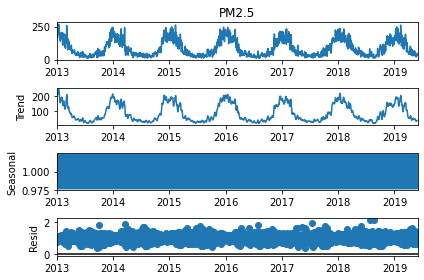

In [51]:
#### Time series plotting
series = df['PM2.5'].asfreq('D')
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pyplot.show()

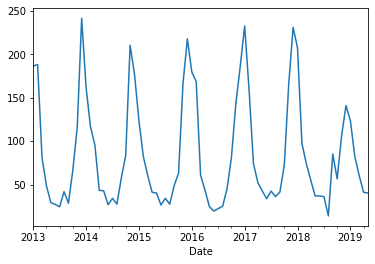

In [52]:
#### Check Monthly plot
df["PM2.5"].asfreq('M').plot()

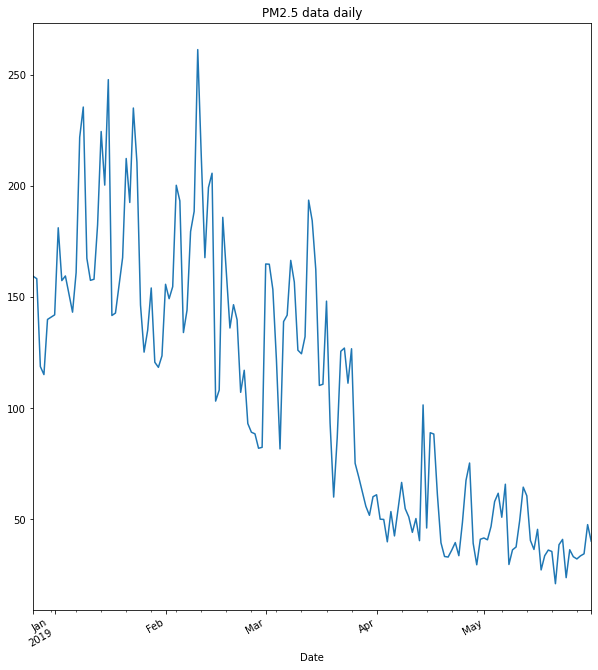

In [53]:
#### Check Dailly plot
df["PM2.5"][df.index>'2018-12-25'].asfreq('D').plot(subplots=True, figsize=(10,12))
plt.title('PM2.5 data daily')
#plt.savefig('stocks.png')
plt.show()

## Dataset Preparation

In [54]:
def create_directory(save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

In [55]:
global save_path
save_path = os.path.join(dataset, 'cross_validation')
create_directory(save_path)

#### Cross validation

In [56]:
data_frame_org = pd.read_csv(csv_path, index_col=0, parse_dates=True)
data_frame = data_frame_org.copy()

In [57]:
def get_k_fold_indexes(data_frame: pd.DataFrame, split:int = 4, cycle:int = 365, lag_days:int = lag)->dict:
    
    """Splits the dataset in "split" parts and returns splitted datasets.
    
    Arguments
    ---------
    data_frame: Original dataset
    split: Number of splits
    cycle: Number of instances in one cycle
    lag_days: previous n days
    
    Returns
    ---------   
    tscv: dict which holds start and end dates of  train, test,validation sets of each folds
    
    """
    
    train_start = 0
    tscv ={}
    for index in range(split):
        if index not in tscv:
            tscv[index] = {}
            tscv[index]['train_start'] = data_frame.iloc[0].name.strftime('%Y-%m-%d')
            tscv[index]['train_end'] = data_frame.iloc[cycle*(index+1)].name.strftime('%Y-%m-%d')
            
            tscv[index]['val_start'] = data_frame.iloc[cycle*(index+1)-lag_days].name.strftime('%Y-%m-%d')
            tscv[index]['val_end'] = data_frame.iloc[cycle*(index+2)].name.strftime('%Y-%m-%d')          

            tscv[index]['test_start'] = data_frame.iloc[cycle*(index+2)-lag_days].name.strftime('%Y-%m-%d')
            tscv[index]['test_end'] = data_frame.iloc[cycle*(index+3)].name.strftime('%Y-%m-%d')
    return tscv

In [58]:
kfold_indexes = get_k_fold_indexes(data_frame)

In [59]:
kfold_indexes

{0: {'train_start': '2013-01-01',
  'train_end': '2014-01-01',
  'val_start': '2013-10-03',
  'val_end': '2015-01-01',
  'test_start': '2014-10-03',
  'test_end': '2016-01-01'},
 1: {'train_start': '2013-01-01',
  'train_end': '2015-01-01',
  'val_start': '2014-10-03',
  'val_end': '2016-01-01',
  'test_start': '2015-10-03',
  'test_end': '2016-12-31'},
 2: {'train_start': '2013-01-01',
  'train_end': '2016-01-01',
  'val_start': '2015-10-03',
  'val_end': '2016-12-31',
  'test_start': '2016-10-02',
  'test_end': '2017-12-31'},
 3: {'train_start': '2013-01-01',
  'train_end': '2016-12-31',
  'val_start': '2016-10-02',
  'val_end': '2017-12-31',
  'test_start': '2017-10-02',
  'test_end': '2018-12-31'}}

#### Cyclical transformation example

In [60]:
def rand_times(n):
    """Generate n rows of random 12 months times (seconds past midnight)"""
    rand_seconds = np.random.randint(0, 52, n)
    return pd.DataFrame(data=dict(seconds=rand_seconds))

n_rows = 1000

df = rand_times(n_rows)
# sort for the sake of graphing
df = df.sort_values('seconds').reset_index(drop=True)
df.head()

,seconds
0,0
1,0
2,0
3,0
4,0


In [61]:
weeks_in_year = 52 # hour*minutes*seconds # 365*52*7

df['sin_time'] = np.sin(2*np.pi*df.seconds/weeks_in_year)
df['cos_time'] = np.cos(2*np.pi*df.seconds/weeks_in_year)

df.drop('seconds', axis=1, inplace=True)

df.head()

,sin_time,cos_time
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


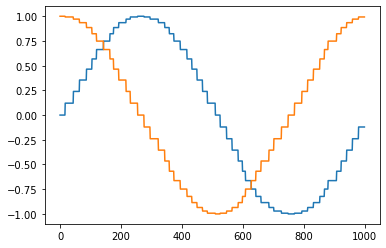

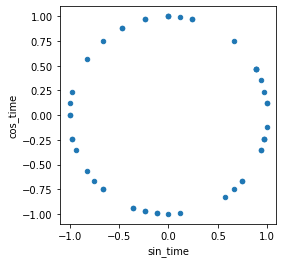

In [62]:
df.sin_time.plot()
df.cos_time.plot()
df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

#### Generate co-variates

In [63]:
def gen_covariates(data_frame: pd.DataFrame, times:pd.core.indexes.datetimes.DatetimeIndex, num_covariates:int , verbose = 0):
    
    """Generates normalized covariates w.r.t the given dataset
    
    Arguments
    ---------
    data_frame: Original dataset
    times: array of dates of the dataframe 
    num_covariates: Number of covariates to use
    
    Returns
    ---------   
    covariates: dataframe with generated covariates
    
    """    

    print(times.shape[0])
    covariates = np.zeros((times.shape[0], num_covariates))
    #print(covariates)
    '''for i, input_time in enumerate(times):
        covariates[i, 1] = input_time.weekday()
        covariates[i, 2] = input_time.week
        covariates[i, 3] = input_time.month'''

    covariates[:, 1] = np.sin(2*np.pi*data_frame.index.weekday/7) #input_time.weekday
    covariates[:, 2] = np.cos(2*np.pi*data_frame.index.weekday/7) #input_time.weekday
    
    covariates[:, 3] = np.sin(2*np.pi*data_frame.index.week/52) #input_time.week
    covariates[:, 4] = np.cos(2*np.pi*data_frame.index.week/52) #input_time.week
    
    covariates[:, 5] = np.sin(2*np.pi*data_frame.index.month/12) #input_time.month
    covariates[:, 6] = np.cos(2*np.pi*data_frame.index.month/12) #input_time.month
    
    #PM2.5	PM10	SO2	CO	NOx	O3	WS	Temp	RH	RF
    #feature_list = ['#WS','WD','T','RH','#SR','BP','#R','NOX','SO2','O3','CO']
    feature_list = ['WS','Temp','RH','RF','NOx','SO2','O3','CO']
    
    for i,val in enumerate(feature_list):
        #print(i+4, (data_frame[val]-data_frame[val].min())/(data_frame[val].max()-data_frame[val].min()))
        covariates[:, i+7] = (data_frame[val]-data_frame[val].min())/(data_frame[val].max()-data_frame[val].min())
    if verbose:
        for i in range(1,num_covariates):
            print(i, covariates[:,i].min(),covariates[:,i].max())
            
    print(covariates[:, :num_covariates].shape, covariates.shape)
    return covariates[:, :num_covariates]

In [64]:
def prep_data(data:pd.DataFrame, covariates:np.ndarray, data_start:np.ndarray, train:bool = True):
    
    """ Preprocess dataset according to window_size, stride and prediction horizon.
    
    Arguments
    ---------
    data: Original dataset
    covariates: generated covariates
    data_start: array of first non zero indexes for all datasets
    train: decide wheather preparing data for training sets
    
    Returns
    ---------   
    x_input: array of x values
    label: array of y values
    prediction_days: array of date of prediction days
    
    """    
    
    dates = data.index.strftime('%Y-%m-%d').values
    data = data.values
    
    #print("train: ", train)
    time_len = data.shape[0]
    print("time_len: ", time_len)
    input_size = window_size-stride_size
    print(num_series)
    windows_per_series = np.full((num_series), (time_len-input_size) // stride_size) # here series~time_series
    if train: windows_per_series -= (data_start+stride_size-1) // stride_size
        
    print("windows_per_series, windows_per_series.shape , input_size: ", windows_per_series, windows_per_series.shape, input_size)

    print("data_start: ", data_start, data_start.shape)
    #print("windows: ", windows_per_series, windows_per_series.shape)
    total_windows = np.sum(windows_per_series)
    #print('total_windows:',total_windows)
    x_input = np.zeros((total_windows, window_size-pred_days, 1+num_covariates), dtype='float32') 
    label = np.zeros((total_windows, pred_days,1), dtype='float32') # shape: total_windows, predicted values per window
    prediction_days = np.zeros((total_windows, 1), dtype= object)
    
    #v_input = np.zeros((total_windows, 1), dtype='float32')
    #cov = 3: ground truth + age + day_of_week + hour_of_day + num_series
    #cov = 4: ground truth + age + day_of_week + hour_of_day + month_of_year + num_series

    count = 0 # number of windows
    if not train:
        covariates = covariates[-time_len:]
    for series in range(num_series):
        cov_index = stats.zscore(np.arange(total_time-data_start[series]))
        if train:
            covariates[data_start[series]:time_len, 0] = cov_index[:time_len-data_start[series]]
            #print('data_start[series]:time_len',data_start[series],time_len )
        else:
            covariates[:, 0] = cov_index[-time_len:]
            #print('-time_len', -time_len)
            
        #print(total_time, data_start[series])
        for i in range(windows_per_series[series]): #iterate through the windows of the series: total_observation//stride size
            if train:
                window_start = stride_size*i+data_start[series] # first non zero index: 8759, window_start = 8759
            else:
                window_start = stride_size*i
            window_end = window_start+window_size # window_end = 8951
            if count<3:
                print('series:', series, ',count:', count, ',i:', i)
                #print("x: ", x_input[count, 1:, 0].shape)
                print("window start: ", window_start)
                print("window end: ", window_end)
                #print("data: ", data.shape)
                #print("d: ", data[window_start:window_end-1, series].shape)
            
            x_input[count, :, 0] = data[window_start:window_end-pred_days, series] # excluding LAST 7 hours value
            #print('pm2.5: ', x_input[count, :, 0][0:5])
            #print('covariates[window_start:window_end-pred_days, 0]', covariates[window_start:window_end-pred_days, 0][0:10])
            x_input[count, :, 1:num_covariates+1] = covariates[window_start:window_end-pred_days, :]
            #print('x_input[count, :, 1]', x_input[count, :, 1][0:10])
            prediction_days[count] = str(dates[window_end-pred_days])
            label[count,:,0] = data[window_end-pred_days:window_end, series] # label includes future pred_days which is to be forecasted
            count += 1

    print(x_input.shape, label.shape)#, v_input.shape)
    return x_input, label, prediction_days


#### Prepare datasets from cross validation 

In [65]:
kfold_prepared_data = {}
data_frame_total = data_frame_org.copy()
data_frame = data_frame_org.iloc[:,0:1]

for index in kfold_indexes:

    train_start = kfold_indexes[index]['train_start']
    train_end = kfold_indexes[index]['train_end']

    validation_start = kfold_indexes[index]['val_start']
    validation_end = kfold_indexes[index]['val_end']

    test_start = kfold_indexes[index]['test_start']
    test_end = kfold_indexes[index]['test_end']

    #train_data = data_frame[train_start:train_end].values
    train_data = data_frame[train_start:train_end]
    #validation_data = data_frame[validation_start:validation_end].values
    validation_data = data_frame[validation_start:validation_end]
    #test_data = data_frame[test_start:test_end].values
    test_data = data_frame[test_start:test_end]
    
    
    
    data_start = (train_data.values!=0).argmax(axis=0) #find first nonzero value in each time series
    total_time = data_frame[train_start:test_end].shape[0] #2342 days total
    num_series = data_frame[train_start:test_end].shape[1] #1
    
    ##############################Generate Train Data#######################################
    covariates = gen_covariates(data_frame_total[train_start:train_end], data_frame_total[train_start:train_end].index, num_covariates)
    covariates = np.around(covariates,5)
    covariates = np.float32(covariates)
    x_input_train,label_train, pred_days_train = prep_data(train_data, covariates, data_start, train=True)
    ########################################################################################

    ### ##########################Generate validation_data#################################
    print('\n Validation\n')
    covariates = gen_covariates(data_frame_total[validation_start:validation_end], data_frame_total[validation_start:validation_end].index, num_covariates)
    covariates = np.around(covariates,5)
    covariates = np.float32(covariates)
    x_input_val,label_val, pred_days_val = prep_data(validation_data, covariates, data_start, train=False)
    ########################################################################################

    ###############################Generate test_data#######################################
    print('\n Test\n')
    covariates = gen_covariates(data_frame_total[test_start:test_end], data_frame_total[test_start:test_end].index, num_covariates)
    covariates = np.around(covariates,5)
    covariates = np.float32(covariates)
    x_input_test,label_test, pred_days_test = prep_data(test_data, covariates, data_start, train=False)
    ########################################################################################
    
    if index not in kfold_prepared_data:
        kfold_prepared_data[index]= {}
        kfold_prepared_data[index]['x_input_train'] = x_input_train
        kfold_prepared_data[index]['label_train'] = label_train
        kfold_prepared_data[index]['prediction_day_train'] = pred_days_train
        
        kfold_prepared_data[index]['x_input_val'] = x_input_val
        kfold_prepared_data[index]['label_val'] = label_val
        kfold_prepared_data[index]['prediction_day_val'] = pred_days_val
        
        kfold_prepared_data[index]['x_input_test'] = x_input_test
        kfold_prepared_data[index]['label_test'] = label_test
        kfold_prepared_data[index]['prediction_day_test'] = pred_days_test
        
    #print(x_input_train.shape,label_train.shape, x_input_val.shape, label_val.shape, x_input_test.shape, label_test.shape)
    #break

366
(366, 16) (366, 16)
time_len:  366
1
windows_per_series, windows_per_series.shape , input_size:  [269] (1,) 97
data_start:  [0] (1,)
series: 0 ,count: 0 ,i: 0
window start:  0
window end:  98
series: 0 ,count: 1 ,i: 1
window start:  1
window end:  99
series: 0 ,count: 2 ,i: 2
window start:  2
window end:  100
(269, 91, 17) (269, 7, 1)

 Validation

456
(456, 16) (456, 16)
time_len:  456
1
windows_per_series, windows_per_series.shape , input_size:  [359] (1,) 97
data_start:  [0] (1,)
series: 0 ,count: 0 ,i: 0
window start:  0
window end:  98
series: 0 ,count: 1 ,i: 1
window start:  1
window end:  99
series: 0 ,count: 2 ,i: 2
window start:  2
window end:  100
(359, 91, 17) (359, 7, 1)

 Test

456
(456, 16) (456, 16)
time_len:  456
1
windows_per_series, windows_per_series.shape , input_size:  [359] (1,) 97
data_start:  [0] (1,)
series: 0 ,count: 0 ,i: 0
window start:  0
window end:  98
series: 0 ,count: 1 ,i: 1
window start:  1
window end:  99
series: 0 ,count: 2 ,i: 2
window start:  

#### Save prepared cross validate data to files

In [66]:
#check if there is nan
assert not np.any(np.isnan(kfold_prepared_data[3]['x_input_train']))# check if none is in the dataset

for index in kfold_prepared_data:

    folder_path = os.path.join(save_path,str(index))
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    print('\n\nFold', index)
    print('Train', kfold_prepared_data[index]['x_input_train'].shape,kfold_prepared_data[3]['label_train'].shape )
    print('Val',kfold_prepared_data[index]['x_input_val'].shape, kfold_prepared_data[3]['label_val'].shape)
    print('Test',kfold_prepared_data[index]['x_input_test'].shape, kfold_prepared_data[3]['label_test'].shape)
    
    np.save(os.path.join(folder_path, dataset+'_data_train'),  kfold_prepared_data[index]['x_input_train'])
    np.save(os.path.join(folder_path, dataset+'_data_validation'),  kfold_prepared_data[index]['x_input_val'])
    np.save(os.path.join(folder_path, dataset+'_data_test'),  kfold_prepared_data[index]['x_input_test'])
    
    np.save(os.path.join(folder_path, dataset+'_label_train'),  kfold_prepared_data[index]['label_train'])
    np.save(os.path.join(folder_path, dataset+'_label_validation'),  kfold_prepared_data[index]['label_val'])
    np.save(os.path.join(folder_path, dataset+'_label_test'),  kfold_prepared_data[index]['label_test'])
    
    np.save(os.path.join(folder_path, dataset+'_prediction_day_train'),  kfold_prepared_data[index]['prediction_day_train'])
    np.save(os.path.join(folder_path, dataset+'_prediction_day_validation'),  kfold_prepared_data[index]['prediction_day_val'])
    np.save(os.path.join(folder_path,dataset+'_prediction_day_test'),  kfold_prepared_data[index]['prediction_day_test'])



Fold 0
Train (269, 91, 17) (1364, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


Fold 1
Train (634, 91, 17) (1364, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


Fold 2
Train (999, 91, 17) (1364, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


Fold 3
Train (1364, 91, 17) (1364, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


#### check prepared data

In [80]:
### check pearson correlation
covariates_full = gen_covariates(data_frame_total[train_start:test_end], data_frame_total[train_start:test_end].index, num_covariates)
#covariates.shape, x_input_train.shape
for i in range(3,num_covariates):
    print(pearsonr(data_frame[train_start:test_end].values[:,0],covariates_full[:,i]))

2191
(2191, 16) (2191, 16)
(0.2638107343399239, 3.3025061625095535e-36)
(0.8333183390158698, 0.0)
(0.41679570916316194, 8.080546397036663e-93)
(0.7553264705483869, 0.0)
(-0.4102194368366662, 1.0783754782898509e-89)
(-0.7741342797117188, 0.0)
(-0.40803645019083373, 1.134574386370483e-88)
(-0.13251797262594162, 4.758847533341581e-10)
(0.3155056221447189, 7.767737610163026e-52)
(0.13619300004253826, 1.5421451709904127e-10)
(0.15346906462844223, 5.110701283224865e-13)
(0.24379777126848762, 5.182309495737407e-31)
(nan, nan)


In [81]:
def covariate_test(x_input_train, num_covariates, covariates):
    for i in range(0,num_covariates):
        #print('i',i)
        if (covariates[0:(window_size-pred_days), i]==x_input_train[0, :, i+1]).all(): # check if covariates matches
            print("covariates index, for prepared dataset index:",i,i+1)
        #print( covariates[0:95, i].shape, x_input_train[0, :, i+1].shape)

In [82]:
covariate_test(x_input_test, num_covariates, covariates)

covariates index, for prepared dataset index: 0 1
covariates index, for prepared dataset index: 1 2
covariates index, for prepared dataset index: 2 3
covariates index, for prepared dataset index: 3 4
covariates index, for prepared dataset index: 4 5
covariates index, for prepared dataset index: 5 6
covariates index, for prepared dataset index: 6 7
covariates index, for prepared dataset index: 7 8
covariates index, for prepared dataset index: 8 9
covariates index, for prepared dataset index: 9 10
covariates index, for prepared dataset index: 10 11
covariates index, for prepared dataset index: 11 12
covariates index, for prepared dataset index: 12 13
covariates index, for prepared dataset index: 13 14
covariates index, for prepared dataset index: 14 15
covariates index, for prepared dataset index: 15 16


#### Check sequential compatibility

In [83]:
def sequential_test(x_input_test, num_covariates):
    for index in range(num_covariates):
        print(index)
        for i,values in enumerate(x_input_test[0:2,:,index:index+1]):
            if i!=0:
                if (prev == values[0]):
                    print('sequential data')
            prev = values[1]

In [84]:
sequential_test(x_input_test, num_covariates)

0
sequential data
1
sequential data
2
sequential data
3
sequential data
4
sequential data
5
sequential data
6
sequential data
7
sequential data
8
sequential data
9
sequential data
10
sequential data
11
sequential data
12
sequential data
13
sequential data
14
sequential data
15
sequential data
